In [ ]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

Data preprocessing

In [ ]:
img_directory ='/content/drive/MyDrive/butterfly/images'
mask_directory='/content/drive/MyDrive/butterfly/masks'

In [ ]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_seg0.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + imgNames[i]) 
            mask = plt.imread(maskAddr + maskNames[i])
            
        except:
            print("hello")
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/content/drive/MyDrive/butterfly/images', 
                        maskPath = '/content/drive/MyDrive/butterfly/masks'
                        )

In [ ]:
image_dataset= np.array(framObjTrain['img'])
mask_dataset = np.array(framObjTrain['mask'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), test_size = 0.20, random_state = 0)

In [ ]:
image_dataset.shape

(832, 128, 128, 3)

In [ ]:
mask_dataset.shape

(832, 128, 128)

Sanity Check

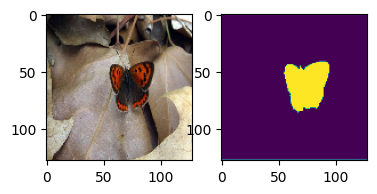

In [ ]:
## displaying data loaded by our function
plt.subplot(2,3,1)
plt.imshow(X_train[3])
plt.subplot(2,3,2)
plt.imshow(y_train[3])
plt.show()

Building U-Net model

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

Compiling the model

In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
unet = build_unet_model()
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

Training the model

In [ ]:
history = unet.fit(X_train, y_train, 
                    batch_size = 16, 
                     verbose=1, 
                     epochs=10, 
                     validation_data=(X_test, y_test), 
                     shuffle=False,
                                    )

Epoch 1/10
42/42 [==============================] - 49s 535ms/step - loss: 0.5371 - accuracy: 0.7346 - val_loss: 0.4686 - val_accuracy: 0.7798
Epoch 2/10
42/42 [==============================] - 12s 280ms/step - loss: 0.3952 - accuracy: 0.8044 - val_loss: 0.4307 - val_accuracy: 0.7950
Epoch 3/10
42/42 [==============================] - 12s 283ms/step - loss: 0.3682 - accuracy: 0.8214 - val_loss: 0.3931 - val_accuracy: 0.8125
Epoch 4/10
42/42 [==============================] - 12s 283ms/step - loss: 0.3309 - accuracy: 0.8453 - val_loss: 0.3619 - val_accuracy: 0.8291
Epoch 5/10
42/42 [==============================] - 12s 285ms/step - loss: 0.3014 - accuracy: 0.8608 - val_loss: 0.3595 - val_accuracy: 0.8346
Epoch 6/10
42/42 [==============================] - 12s 285ms/step - loss: 0.2824 - accuracy: 0.8731 - val_loss: 0.3436 - val_accuracy: 0.8359
Epoch 7/10
42/42 [==============================] - 12s 288ms/step - loss: 0.2572 - accuracy: 0.8836 - val_loss: 0.2972 - val_accuracy: 0.8608

plotting validation and accuracy

In [1]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
X_test.shape

(167, 128, 128, 3)

In [ ]:
X_train.shape

(665, 128, 128, 3)

predicting values

In [ ]:
def predict16 (valMap, model, shape = 128):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,4,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,4,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')
    
    imh = predMask
    imh[imh < 0.5] = 0
    imh[imh > 0.5] = 1

In [ ]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)

26/26 [==============================] - 3s 134ms/step


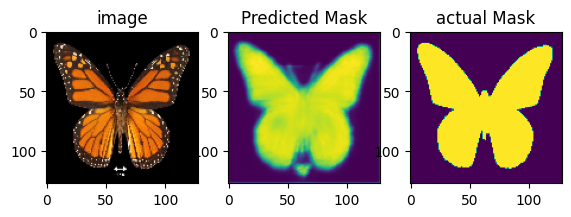

In [ ]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

Evaluation of the model

In [ ]:
# import numpy as np

# # Reshape y_test to have shape (167, 128, 128, 1)
# y_test_reshaped = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, jaccard_score

In [ ]:
import numpy as np

y_test = np.expand_dims(y_test, axis=-1)


In [ ]:
# import numpy as np
# y_pred=unet.predict(X_test)

# # Reshape y_test to have shape (167, 128, 128, 1)
# y_test_reshaped = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

# # Squeeze the last dimension from y_pred
# y_pred = np.squeeze(y_pred, axis=-1)

# # Now y_pred_squeezed has shape (167, 128, 128), matching y_test_reshaped


In [ ]:
#Calculation of evaluation metrices

In [ ]:
y_pred=unet.predict(X_test)
y_pred_thresholded = y_pred >0.3


intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


6/6 [==============================] - 1s 134ms/step
IoU socre is:  0.7063812817135691


In [ ]:
# Dice Coefficient
dice_coef = (2 * np.sum(y_test * y_pred)) / (np.sum(y_test) + np.sum(y_pred))

In [ ]:
dice_coef

0.705866826649466

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve

# Flatten the y_test and y_pred arrays
y_test_flat = y_test.ravel()
y_pred_flat = y_pred_thresholded.ravel()

In [ ]:
y_test.dtype

dtype('float32')

In [ ]:
threshold = 0.5
y_pred_thresholded = (y_pred > threshold).astype(int)
y_true_thresholded = (y_test > threshold).astype(int)


In [ ]:
#calculation of precision
from sklearn.metrics import precision_score

y_pred_thresholded = (y_pred > 0.3).astype(int)
precision = precision_score(y_true_thresholded.flatten(), y_pred_thresholded.flatten())
print("Precision: ", precision)


Precision:  0.7848429054354068


In [ ]:
recall = recall_score(y_true_thresholded.flatten(), y_pred_thresholded.flatten())
print("recall: ", recall)

recall:  0.8859085787756596


In [ ]:
f1 = f1_score(y_true_thresholded.flatten(), y_pred_thresholded.flatten())
print("f1_score: ", f1)

f1_score:  0.832318952863014


In [ ]:
# Calculate Accuracy
accuracy = accuracy_score(y_true_thresholded.flatten(), y_pred_thresholded.flatten())
print('Accuracy:', accuracy)

Accuracy: 0.9023890695172155


In [ ]:
# Calculate ROC-AUC Score and ROC Curve
roc_auc = roc_auc_score(y_true_thresholded.flatten(), y_pred_thresholded.flatten())
fpr, tpr, _ = roc_curve(y_true_thresholded.flatten(), y_pred_thresholded.flatten())
print('ROC-AUC Score:', roc_auc)

ROC-AUC Score: 0.8972502599017486


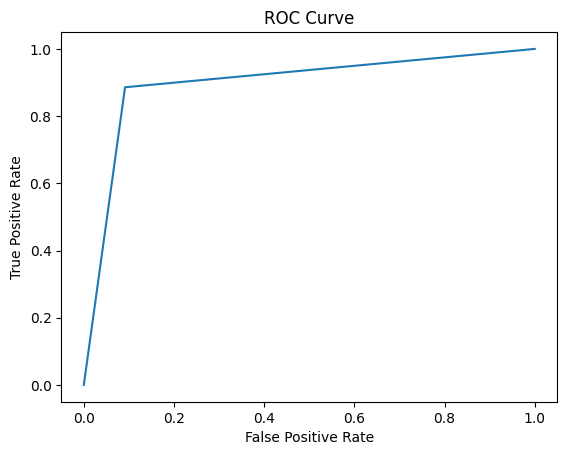

In [ ]:
# Plot the ROC Curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()